# Position Reconstruction for XeBRA - Neural Networks - Measurements Analysis

**Status:** August 2019

Position reconstruction for XeBRA using a feedforward neural network with Keras.

In [1]:
## Imports:

!python -V

import os
import sys
import glob

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
from matplotlib.image import NonUniformImage
from matplotlib.patches import Rectangle
%matplotlib inline
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

import pandas as pd
print('pandas version = '+str(pd.__version__))
import numpy as np
import math

import keras
print('keras version = '+str(keras.__version__))
from keras.models import Sequential,Model,load_model
from keras.layers import Input,Dense,Dropout,Activation
from keras.optimizers import SGD,Adam
from keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split

from ann_visualizer.visualize import ann_viz

from scipy.interpolate import griddata

Python 3.7.3
pandas version = 0.25.0


Using TensorFlow backend.


keras version = 2.2.4


## General Definitions and Parameters

In [2]:
#### General function definitions:

def f_polar_R(cartesian_x, cartesian_y):
    return np.sqrt(cartesian_x * cartesian_x + cartesian_y * cartesian_y)

def f_polar_Phi(cartesian_x, cartesian_y):
    return np.arctan2(cartesian_y, cartesian_x)

def f_distance(x_a, y_a, x_b, y_b):
    return np.sqrt((x_b - x_a)**2 + (y_b - y_a)**2)


def flatten_tuples(tup):
    return np.array([element for tupl in tup for element in tupl])

def sum_tuple_subentries(tup):
    return [np.sum(tupl) for tupl in tup]

def nth_tuple_subentries(tup, n):
    return [tupl[n] for tupl in tup]


def from_np_array(array_string):
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.array(ast.literal_eval(array_string))

In [3]:
## PMT properties

R8520_body_width = 25.7
R8520_body_cornerradius = 2.
R8520_photocathode_width = 20.5
R8520_photocathode_cornerradius = 1.

PMT_ID = np.array([1,2,3,4,5,6,7])

PMT_position_x = np.array([-14.,-28,-14.,14.,28.,14.,0.])      # x-position PMTs in mm in cartesian coordinates
PMT_position_y = np.array([-28.,0.,28.,28.,0.,-28.,0.])        # y-position PMTs in mm in cartesian coordinates
PMT_position_R = f_polar_R(PMT_position_x, PMT_position_y)     # radial position PMTs in mm in polar coordinates
PMT_position_Phi = f_polar_Phi(PMT_position_x, PMT_position_y) # angular position PMTs in rad in polar coordinates

PMT_positions = pd.DataFrame(index=PMT_ID, data={'PMT_ID': PMT_ID, 'PMT_position_x': PMT_position_x, 'PMT_position_y': PMT_position_y, 'PMT_position_R': PMT_position_R, 'PMT_position_Phi': PMT_position_Phi})
PMT_positions

,PMT_ID,PMT_position_x,PMT_position_y,PMT_position_R,PMT_position_Phi
1,1,-14.0,-28.0,31.304952,-2.034444
2,2,-28.0,0.0,28.000000,3.141593
3,3,-14.0,28.0,31.304952,2.034444
4,4,14.0,28.0,31.304952,1.107149
5,5,28.0,0.0,28.000000,0.000000
6,6,14.0,-28.0,31.304952,-1.107149
7,7,0.0,0.0,0.000000,0.000000


## Imports and Data Processing

In [4]:
## Selection of file to be analyzed:

## Use single file and split it (1) or 
## separate train and test files (2) or 
## list of files of same type and split it (3)
file_selection = 3
if (file_selection == 1 or file_selection == 3):
    file_split_train = 0.9 # fraction of file used for training if file_selection = 1 or 3

## Selection of file(s) to be used:
if file_selection == 1:
    filename       = '/media/ab602/TOSHIBA EXT/Simulation_Data/LCE/optPhot_S2_1.0e+05_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04.root'
    filename_list = [filename]
if file_selection == 2:
    ## train file
    filename_train = '/media/ab602/TOSHIBA EXT/Simulation_Data/LCE/optPhot_S2_1.0e+05_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04.root'
    ## predict file
    filename       = '/media/ab602/TOSHIBA EXT/Simulation_Data/LCE/optPhot_S2_1.0e+04_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04.root'
    filename_list = [filename]
if file_selection == 3:
    filename_list = glob.glob("/media/ab602/TOSHIBA EXT/Simulation_Data/LCE/optPhot_S2_1.0e+05_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_*.root")
    exec('n_events = '+str(len(filename_list))+'*'+filename_list[0][filename_list[0].find('e+')-3:filename_list[0].find('e+')+4])
    filename       = filename_list[0][:filename_list[0].find('e+')-3]+"{:.1e}".format(n_events)+filename_list[0][filename_list[0].find('e+')+4:-7]+'.root'

print('Files selected:\n')
for el in filename_list:
    print(el)
print('')
    
## filename prefix for automatically naming outputs

if (file_selection == 1 or file_selection == 3):
    
    if filename[:45] == '/media/ab602/TOSHIBA EXT/Simulation_Data/LCE/':
        filenameprefix = filename[:-5][45:]
    elif filename[:44] == '/media/alex/TOSHIBA EXT/Simulation_Data/LCE/':
        filenameprefix = filename[:-5][44:]
    else:
        filenameprefix = 'filenameprefix'

if file_selection == 2:
    
    if filename_train[:45] == '/media/ab602/TOSHIBA EXT/Simulation_Data/LCE/':
        filenameprefix_train = filename_train[:-5][45:]
    elif filename_train[:44] == '/media/alex/TOSHIBA EXT/Simulation_Data/LCE/':
        filenameprefix_train = filename_train[:-5][44:]
    else:
        filenameprefix_train = 'filenameprefix_train'
    print('filenameprefix_train = '+filenameprefix_train)
    
    if filename[:45] == '/media/ab602/TOSHIBA EXT/Simulation_Data/LCE/':
        filenameprefix = filename[:-5][45:]
    elif filename[:44] == '/media/alex/TOSHIBA EXT/Simulation_Data/LCE/':
        filenameprefix = filename[:-5][44:]
    else:
        filenameprefix = 'filenameprefix'
    
filenameprefix = 'MCfakemeasurement_' + filenameprefix

Files selected:

/media/ab602/TOSHIBA EXT/Simulation_Data/LCE/optPhot_S2_1.0e+05_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_5.root
/media/ab602/TOSHIBA EXT/Simulation_Data/LCE/optPhot_S2_1.0e+05_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_6.root
/media/ab602/TOSHIBA EXT/Simulation_Data/LCE/optPhot_S2_1.0e+05_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_7.root
/media/ab602/TOSHIBA EXT/Simulation_Data/LCE/optPhot_S2_1.0e+05_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_8.root
/media/ab602/TOSHIBA EXT/Simulation_Data/LCE/optPhot_S2_1.0e+05_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_9.root
/media/ab602/TOSHIBA EXT/Simulation_Data/LCE/optPhot_S2_1.0e+05_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_1.root
/media/ab602/TOSHIBA EXT/Simulation_Data/LCE/optPhot_S2_1.0e+05_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_wri

In [5]:
print(filenameprefix)

MCfakemeasurement_optPhot_S2_1.0e+06_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04


In [6]:
## Import as pandas dataframes

import uproot
import pandas as pd

branches= ['xp_pri','yp_pri','zp_pri','nbpmthits','ntpmthits','pmthits'] # Be careful that the branches are also initilized in _chunk_collect

import concurrent.futures
executor = concurrent.futures.ThreadPoolExecutor(8)

_chunk_collect = pd.DataFrame({'xp_pri' : [],'yp_pri' : [],'zp_pri' : [],'nbpmthits' : [],'ntpmthits' : [],'pmthits' : []}) # Initialize empty data frame

for _chunk in uproot.iterate(filename_list, "events/events",branches, entrysteps=100000, 
                                       outputtype=pd.DataFrame, executor=executor):
    _chunk.columns=branches
    _chunk_collect = _chunk_collect.append(_chunk)
    print('.', end = '')
print('\n')
    
if filenameprefix.find('nop') > 0:
    nop_string = filenameprefix[(filenameprefix.find('nop')+4) : (filenameprefix.find('+', filenameprefix.find('nop')+4)+3)]
    exec('nop = '+nop_string)
    print('nop = '+str(nop))
    _chunk_collect['nbpmthits'] = _chunk_collect['nbpmthits'] / nop
    _chunk_collect['ntpmthits'] = _chunk_collect['ntpmthits'] / nop
    _chunk_collect['pmthits'] = _chunk_collect['pmthits'] / nop
else:
    print('Error: Number of particles per event = 1!')
    
## Separate hits for individual PMTs
## Takes a while to calculate...
for i in range(0,8):
    _chunk_collect['pmthits_'+str(i)] = pd.Series(nth_tuple_subentries(np.asarray(_chunk_collect['pmthits']), i), index=_chunk_collect.index)
    print(i, end=' ')
    
## Total PMT hits
_chunk_collect['napmthits'] = pd.Series(_chunk_collect.nbpmthits+_chunk_collect.ntpmthits, index=_chunk_collect.index)

/home/ab602/anaconda3/lib/python3.7/site-packages/uproot/tree.py:116: FutureWarning: Int64Index.data is deprecated and will be removed in a future version
  index = awkward.numpy.frombuffer(arrays.index.data, dtype=arrays.index.dtype)


..........

nop = 10000.0
0 1 2 3 4 5 6 7 

In [7]:
HF_list = np.array([np.array(_chunk_collect['pmthits_1'])/np.array(_chunk_collect['ntpmthits']),
                    np.array(_chunk_collect['pmthits_2'])/np.array(_chunk_collect['ntpmthits']), 
                    np.array(_chunk_collect['pmthits_3'])/np.array(_chunk_collect['ntpmthits']),
                    np.array(_chunk_collect['pmthits_4'])/np.array(_chunk_collect['ntpmthits']), 
                    np.array(_chunk_collect['pmthits_5'])/np.array(_chunk_collect['ntpmthits']), 
                    np.array(_chunk_collect['pmthits_6'])/np.array(_chunk_collect['ntpmthits']), 
                    np.array(_chunk_collect['pmthits_7'])/np.array(_chunk_collect['ntpmthits'])])
HF_list = HF_list[:,0:10000] # reduce statistics

In [8]:
predict_feature = HF_list.T # IMPORTANT!!!
predict_feature.shape

(10000, 7)

## Reconstruction Algorithm

In [9]:
## Load the trained model from corresponding HDF5 file
model = load_model('XeBRA_Position_Reconstruction_NN_Model.h5')
model.summary()

W0826 10:58:20.783411 140502564407104 deprecation_wrapper.py:119] From /home/ab602/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0826 10:58:20.803405 140502564407104 deprecation_wrapper.py:119] From /home/ab602/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0826 10:58:20.886032 140502564407104 deprecation_wrapper.py:119] From /home/ab602/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0826 10:58:20.889820 140502564407104 deprecation_wrapper.py:119] From /home/ab602/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                512       
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
activation_2 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
_________________________________________________________________
activation_3 (Activation)    (None, 2)                 0         
Total params: 4,802
Trainable params: 4,802
Non-trainable params: 0
_________________________________________________________________


## Reconstruction

In [10]:
## Use model to reconstruct positions
predictions = model.predict(predict_feature)

## Rescale
scaling_factor = 70
predictions = predictions*scaling_factor

In [11]:
## Save reconstructed positions in pandas dataframe

d = {'x_pos': predictions[:,0], 'y_pos': predictions[:,1]}
Reconstruction_NN = pd.DataFrame(data=d)
Reconstruction_NN.to_pickle(filenameprefix+"_Reconstruction_NN.pkl")
Reconstruction_NN

## SAVE !!!!!!!!!!!!!!!!!!!!!!!!!!!

,x_pos,y_pos
0,18.397106,17.579727
1,31.665052,-2.186015
2,-16.702953,22.105122
3,-25.734169,16.920139
4,18.514349,-11.042530
5,16.002428,-1.767958
6,-3.453744,9.921898
7,29.494720,9.028007
8,-3.272428,29.475292
9,-1.336394,-3.713645


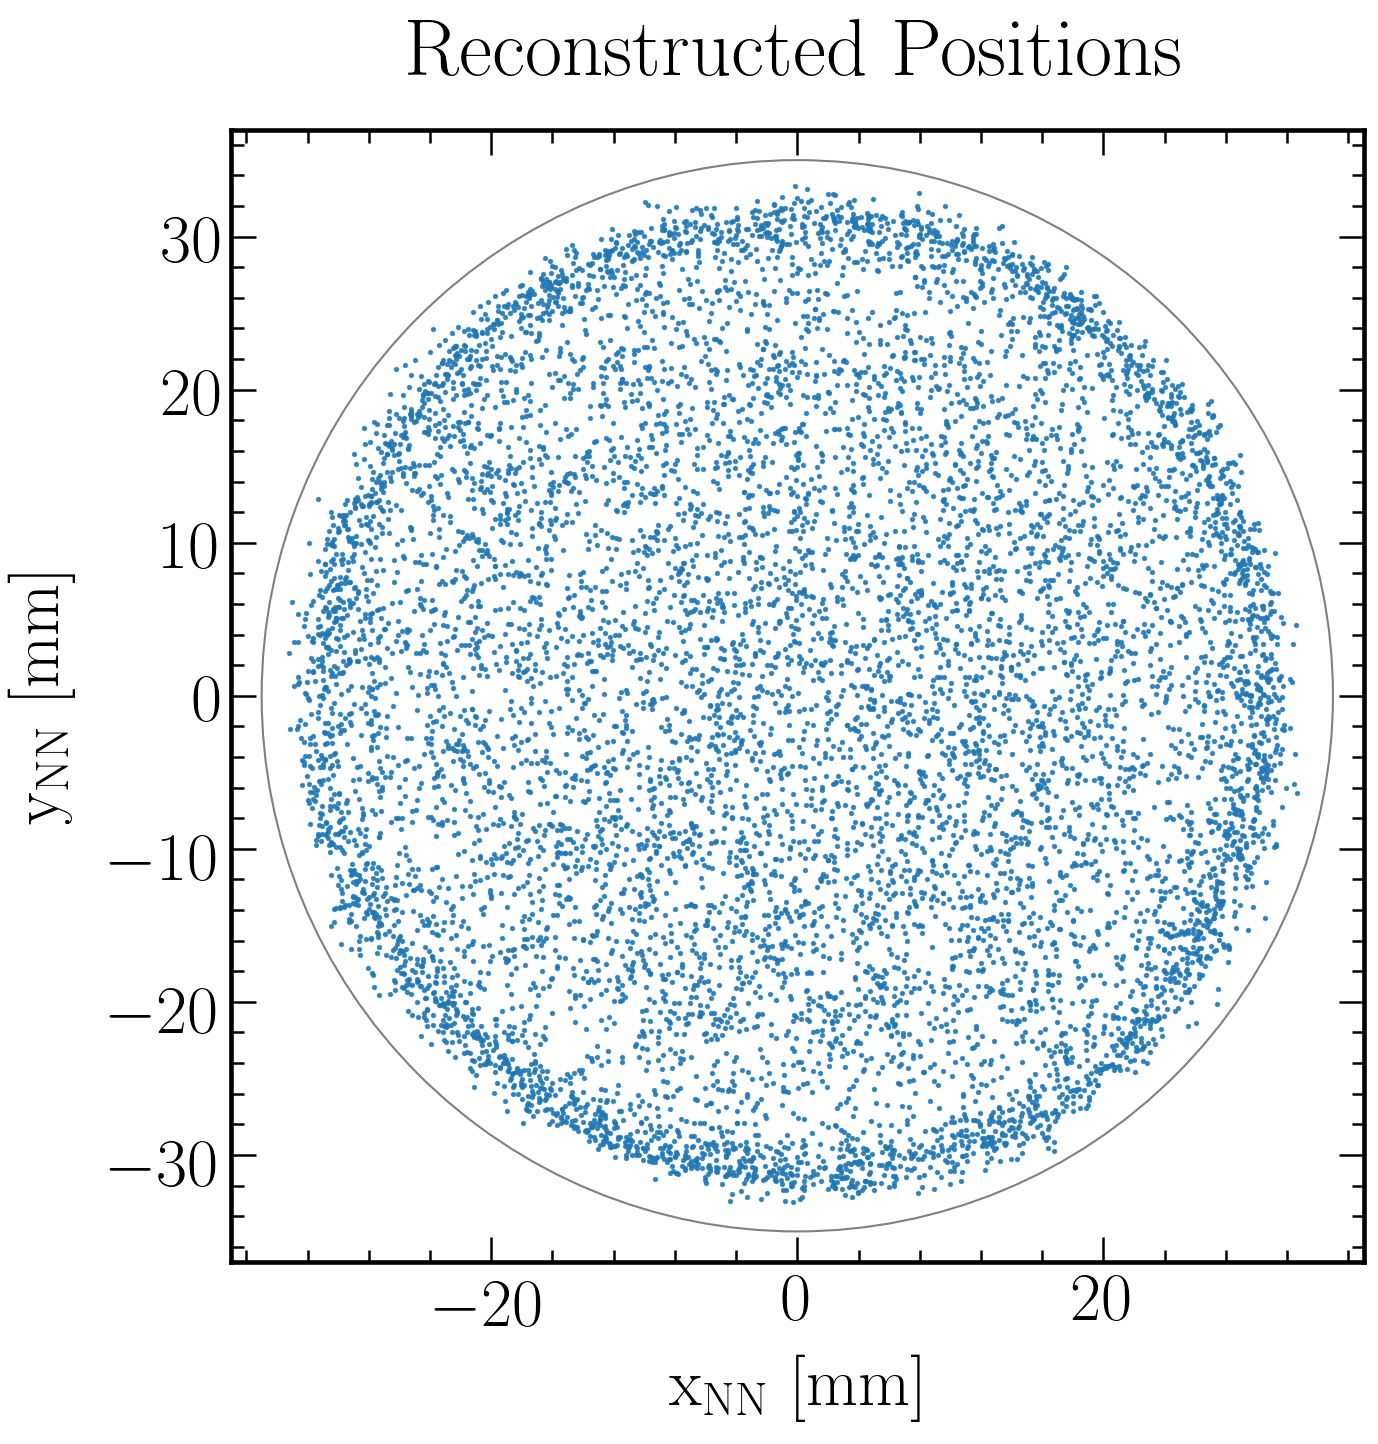

In [12]:
fig=plt.figure(figsize=(16, 10), dpi=150)

## Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Labels
label_size = 32.5
label_pad = 13
title_size = 39
title_pad = 26

## Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

## Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
## Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

## Data plot
plt.scatter(predictions[:,0],
            predictions[:,1],
            marker='.',
            #s=1,
            s = 10,
            ##c='k',
            alpha = 0.8,
           )

plt.xlim(-37,37)
plt.ylim(-37,37)

plt.xlabel('x$_\mathrm{NN}$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('y$_\mathrm{NN}$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.title('Reconstructed Positions', fontsize = title_size, pad = title_pad)

currentAxis = plt.gca()
circle = plt.Circle((0., 0.), 35., color='gray', linestyle = '-', fill=False)
currentAxis.add_artist(circle)

plt.gca().set_aspect('equal', adjustable='box')

plt.show()
fig.savefig(filenameprefix+"_predictions_NN.png", bbox_inches = "tight")